In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
#Funcion para imprimir la matriz de confusión
def matriz_confusion(cm,modelo):
    sns.set(rc={'figure.figsize':(4,4)})
    ax = sns.heatmap(cm,annot=True,fmt='d')
    ax.set_title('Matriz de confusión - modelo '+ modelo)
    plt.xlabel('Predicted')
    plt.ylabel('True')

In [3]:
data = np.loadtxt('wifi_localization.txt',dtype=int)

In [4]:
col = ['wifi1','wifi2','wifi3','wifi4','wifi5','wifi6','wifi7','room']
df = pd.DataFrame(data,columns=col)
df.head()

,wifi1,wifi2,wifi3,wifi4,wifi5,wifi6,wifi7,room
0,-64,-56,-61,-66,-71,-82,-81,1
1,-68,-57,-61,-65,-71,-85,-85,1
2,-63,-60,-60,-67,-76,-85,-84,1
3,-61,-60,-68,-62,-77,-90,-80,1
4,-63,-65,-60,-63,-77,-81,-87,1


In [5]:
df.groupby('room').count()

,wifi1,wifi2,wifi3,wifi4,wifi5,wifi6,wifi7
room,,,,,,,
1,500,500,500,500,500,500,500
2,500,500,500,500,500,500,500
3,500,500,500,500,500,500,500
4,500,500,500,500,500,500,500


In [35]:
df.min()

wifi1   -74
wifi2   -74
wifi3   -73
wifi4   -77
wifi5   -89
wifi6   -97
wifi7   -98
room      1
dtype: int32

In [36]:
df.max()

wifi1   -10
wifi2   -45
wifi3   -40
wifi4   -11
wifi5   -36
wifi6   -61
wifi7   -63
room      4
dtype: int32

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Dividimos el dataset en los conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(df.drop('room',axis=1),
                                                    df['room'], 
                                                    test_size = 0.3, random_state = 0)
#Normalizamos el dataset
x_scaler = StandardScaler()
X_train = x_scaler.fit_transform(X_train)
X_test = x_scaler.transform(X_test)

In [7]:
X_test.shape

(600, 7)

In [8]:
# Importamos librerías
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Desactivamos advertencias en el notebook
import warnings
warnings.filterwarnings('ignore')

## 1. *k* nearest neighbours

Text(21.5, 0.5, 'k neighbors')

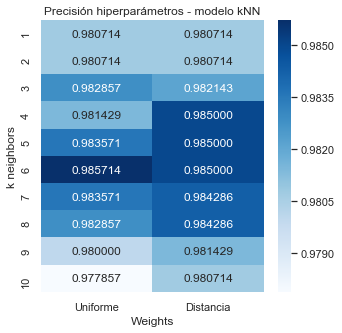

In [9]:
#Definimos valores para k del 1 al 10
k = list(range(1,11))
#Diccionario con los argumentos a pasar a GridSearchCV
grid_params = {'n_neighbors':k,'weights':['uniform','distance']}

#Generamos el modelo
gs = GridSearchCV(KNeighborsClassifier(),grid_params,cv=4)
gs_results = gs.fit(X_train,y_train)
#Obtenemos los resultados de la media de precisión de las iteraciones
a = gs_results.cv_results_['mean_test_score']

#Creamos dataset para visualizar el mapa de calor
b=a.reshape(10,2)
heatmap_df = pd.DataFrame(data=b,index=k,columns=['Uniforme','Distancia'])

#Mapa de calor
sns.set(rc={'figure.figsize':(5,5)})
ax = sns.heatmap(heatmap_df,annot=True,cmap='Blues',fmt='f')
ax.set_title('Precisión hiperparámetros - modelo kNN')
plt.xlabel('Weights')
plt.ylabel('k neighbors')

Escogemos los hiperparámetros k=4 y weight='distancia'

In [10]:
#Confirmamos que los mejores hiperparámetros del heatmap coinciden con los valores del modelo
gs_results.best_params_

{'n_neighbors': 6, 'weights': 'uniform'}

In [11]:
#Características del modelo generado con los hiperparámetros más óptimos
knn = KNeighborsClassifier(n_neighbors = gs_results.best_params_['n_neighbors'], 
                           weights = gs_results.best_params_['weights'])
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                     weights='uniform')

Accuracy del modelo:  0.99


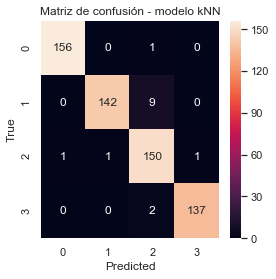

In [34]:
#Hacemos la predicción sobre el conjunto de test
y_pred = knn.predict(X_test)

#Accuracy y heatmap de la predicción
print("Accuracy del modelo: ", knn.score(X_train,y_train))
c_matrix = confusion_matrix(y_test, y_pred)
matriz_confusion(c_matrix,"kNN")


## 2. Support Vector Machines

Text(66.5, 0.5, 'c')

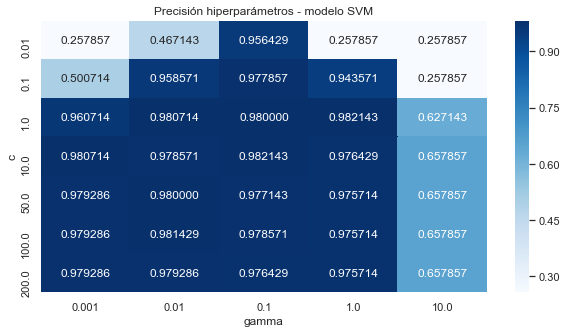

In [13]:
#Importamos librerías a utilizar en esta sección
from sklearn.svm import SVC

#Definimos los valores a comparar de C y gamma
c = [0.01, 0.1, 1, 10, 50, 100, 200]
gamma = [0.001, 0.01, 0.1, 1, 10]
#Diccionario de hipermarametros
grid_params_svc = {'C':c,'gamma':gamma}

#Generamos modelo y aplicamos al conjunto de datos
#Por defecto SVC utiliza un kernel radial
gs_svc = GridSearchCV(SVC(),grid_params_svc,cv=4)
gs_results_svc = gs_svc.fit(X_train,y_train)

#Extraemos informacion sobre los accuracy de cada prueba
a = gs_results_svc.cv_results_['mean_test_score']
#Damos formato de matriz para graficar heatmap y creamos dataset
b=a.reshape(7,5)
heatmap_df_svc = pd.DataFrame(data=b,index=c,columns=gamma)

#Graficamos
sns.set(rc={'figure.figsize':(10,5)})
ax = sns.heatmap(heatmap_df_svc,annot=True,cmap='Blues',fmt='f')
ax.set_title('Precisión hiperparámetros - modelo SVM')
plt.xlabel('gamma')
plt.ylabel('c')

In [14]:
#Confirmamos que los mejores hiperparámetros del heatmap coinciden con los valores del modelo
gs_results_svc.best_params_

{'C': 1, 'gamma': 1}

In [15]:
#Características del modelo generado utilizando los hiperparámetros óptimos
#Por defecto,el modelo SVC utiliza kernel radial: rbf
#Ponemos probability=True ya que la funcion plot_decision_boundaries daba un error en predict_proba
svc = SVC(C = gs_results_svc.best_params_['C'], gamma = gs_results_svc.best_params_['gamma'], probability=True)  
svc.fit(X_train,y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [16]:
#Predicción sobre el conjunto de test
y_pred_svc = svc.predict(X_test)

Accuracy del modelo:  0.9978571428571429


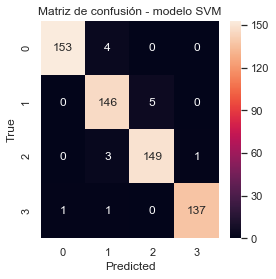

In [17]:
#Accuracy y matriz de confusión del modelo generado
print("Accuracy del modelo: ", svc.score(X_train,y_train))
c_matrix_svc = confusion_matrix(y_test, y_pred_svc)
matriz_confusion(c_matrix_svc,"SVM")

## 3.  Árboles de decisión

Text(66.5, 0.5, 'max_depth')

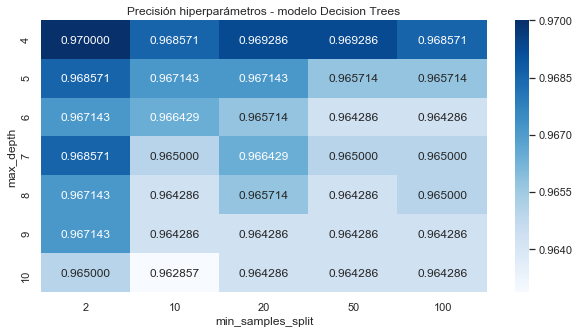

In [18]:
#Importamos librerías
from sklearn.tree import DecisionTreeClassifier

#Valores de depth y samples que se utilizarán
depth = list(range(4,11))
samples = [2, 10, 20, 50, 100]
#Definimos diccionario con hiperparámetros que utilizará GridSearchCV
grid_params_dt = {'max_depth':depth,'min_samples_split':samples}

#Generamos el modelo y aplicamos al dataset de entrenamiento
gs_dt = GridSearchCV(DecisionTreeClassifier(),grid_params_dt,cv=4)
gs_results_dt = gs_dt.fit(X_train,y_train)

#Extraemos la información de accuracy 
a = gs_results_dt.cv_results_['mean_test_score']
#Damos formato de matriz y generamos un dataframe
b=a.reshape(7,5)
heatmap_df_dt = pd.DataFrame(data=b,index=depth,columns=samples)

#Representamos los valores de accuracy en un heatmap
sns.set(rc={'figure.figsize':(10,5)})
ax = sns.heatmap(heatmap_df_dt,annot=True,cmap='Blues',fmt='f')
ax.set_title('Precisión hiperparámetros - modelo Decision Trees')
plt.xlabel('min_samples_split')
plt.ylabel('max_depth')

In [19]:
#Comprobamos mejores hiperparámetros
gs_results_dt.best_params_

{'max_depth': 4, 'min_samples_split': 2}

In [20]:
#Características del modelo generado con los hiperparámetros óptimos
dt = DecisionTreeClassifier(max_depth = gs_results_dt.best_params_['max_depth'], 
                            min_samples_split = gs_results_dt.best_params_['min_samples_split'])
dt.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [21]:
#Predecimos clases en el conjunto de test
y_pred_dt = dt.predict(X_test)

Accuracy del modelo:  0.9764285714285714


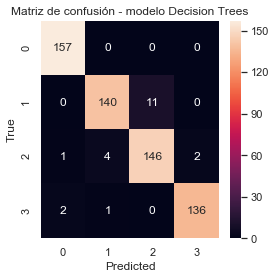

In [22]:
#Accuracy y heatmap del resultado de la predicción
print("Accuracy del modelo: ", dt.score(X_train,y_train))
c_matrix_dt = confusion_matrix(y_test, y_pred_dt)
matriz_confusion(c_matrix_dt,"Decision Trees")

## 4. Random Forest

Text(66.5, 0.5, 'max_depth')

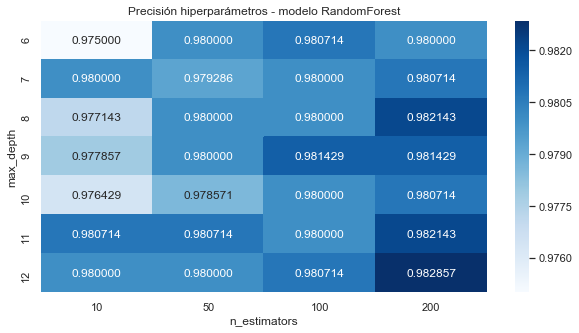

In [23]:
#Importamos modelo
from sklearn.ensemble import RandomForestClassifier

#Definimos valores a probar
max_depth = list(range(6,13))
n = [10, 50, 100, 200]
#Diccionario con los hiperparámetros
grid_params_rf = {'max_depth':max_depth,'n_estimators':n,'random_state':[0]}

#Geneamos el modelo y lo aplicamos al conjunto de entrenamiento
gs_rf = GridSearchCV(RandomForestClassifier(),grid_params_rf,cv=4)
gs_results_rf = gs_rf.fit(X_train,y_train)

#Extraemos los valores de accuray
a = gs_results_rf.cv_results_['mean_test_score']
#Damos formato de matriz y creamos un dataframe
b=a.reshape(7,4)
heatmap_df_rf = pd.DataFrame(data=b,index=max_depth,columns=n)

#Mostramos heatmap con valores de accuracy
sns.set(rc={'figure.figsize':(10,5)})
ax = sns.heatmap(heatmap_df_rf,annot=True,cmap='Blues',fmt='f')
ax.set_title('Precisión hiperparámetros - modelo RandomForest')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')

In [24]:
#Comprobamos valores óptimos
gs_results_rf.best_params_

{'max_depth': 12, 'n_estimators': 200, 'random_state': 0}

In [25]:
#Características del modelo generado con hiperparámetros óptimos
rf = RandomForestClassifier(n_estimators = gs_results_rf.best_params_['n_estimators'],
                            max_depth = gs_results_rf.best_params_['max_depth'],
                            random_state=0)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=12, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [26]:
#Predicción sobre el conjunto de test
y_pred_rf = rf.predict(X_test)

Accuracy del modelo:  1.0


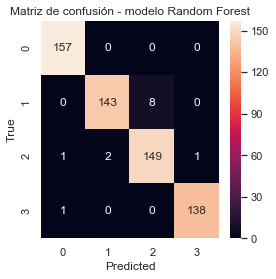

In [27]:
print("Accuracy del modelo: ", rf.score(X_train,y_train))
c_matrix_rf = confusion_matrix(y_test, y_pred_rf)
matriz_confusion(c_matrix_rf,"Random Forest")

## 5. Gradient Boosting

Text(39.5, 0.5, 'learning_rate')

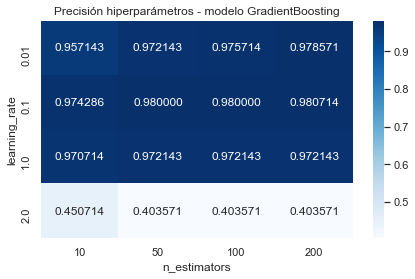

In [28]:
#Importamos modelo
from sklearn.ensemble import GradientBoostingClassifier

#Definimos valores que vamos a utilizar
learning = [0.01, 0.1, 1, 2]
n = [10, 50, 100, 200]
#Diccionario con hiperparámetros
grid_params_gb = {'learning_rate':learning,'n_estimators':n,'random_state':[0]}

#Generamos modelo y ajustamos al conjunto de entrenamiento
gs_gb = GridSearchCV(GradientBoostingClassifier(),grid_params_gb,cv=4)
gs_results_gb = gs_gb.fit(X_train,y_train)

#Extraemos valores de accuracy
a = gs_results_gb.cv_results_['mean_test_score']
#Damos formato de matriz y creamos un dataframe
b=a.reshape(4,4)
heatmap_df_gb = pd.DataFrame(data=b,index=learning,columns=n)

#Graficamos heatmap
sns.set(rc={'figure.figsize':(7,4)})
ax = sns.heatmap(heatmap_df_gb,annot=True,cmap='Blues',fmt='f')
ax.set_title('Precisión hiperparámetros - modelo GradientBoosting')
plt.xlabel('n_estimators')
plt.ylabel('learning_rate')

In [29]:
#Comprobamos valor de hiperparametros óptimo
gs_results_gb.best_params_

{'learning_rate': 0.1, 'n_estimators': 200, 'random_state': 0}

In [30]:
#Características del modelo con hiperparámetros óptimos
gb = GradientBoostingClassifier(n_estimators=gs_results_gb.best_params_['n_estimators'],
                                learning_rate = gs_results_gb.best_params_['learning_rate'],
                                random_state=0)
gb.fit(X_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='auto',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [31]:
#Predecimos clases en el conjunto de test
y_pred_gb = gb.predict(X_test)

Accuracy del modelo:  1.0


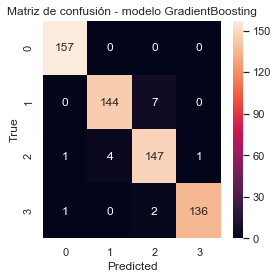

In [32]:
print("Accuracy del modelo: ", gb.score(X_train,y_train))
c_matrix_gb = confusion_matrix(y_test, y_pred_gb)
matriz_confusion(c_matrix_gb,"GradientBoosting")